# Task 1 (3 points)

Generate a toy dataset for the "XOR" problem:

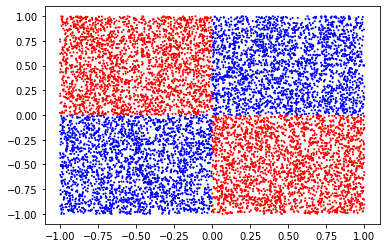

i.e. where the two features are distributed **uniformly** in $[-1, 1]$, and the target is $y = (x_0 >= 0) \text{ XOR } (x_1 >= 0)$.

Let the total number of points in the dataset be $N=10000$.

Fit a `sklearn.tree.DecisionTreeClassifier` on this data. Find a minimal `max_depth` value that results in train accuracy $>0.99$.

For each value of `max_depth` from 1 to the value found above, plot the data with the decision boundary for the obtained model. (*Hint: use `s=1` argument to `plt.scatter` to be able to see anything behind the data points.*)

For the model with train accuracy $>0.99$ use `sklearn.tree.plot_tree` to observe the tree structure.

max_depth: 1, training accuracy: 0.5370
max_depth: 2, training accuracy: 0.5770
max_depth: 3, training accuracy: 0.8050
max_depth: 4, training accuracy: 0.9960
max_depth: 5, training accuracy: 1.0000


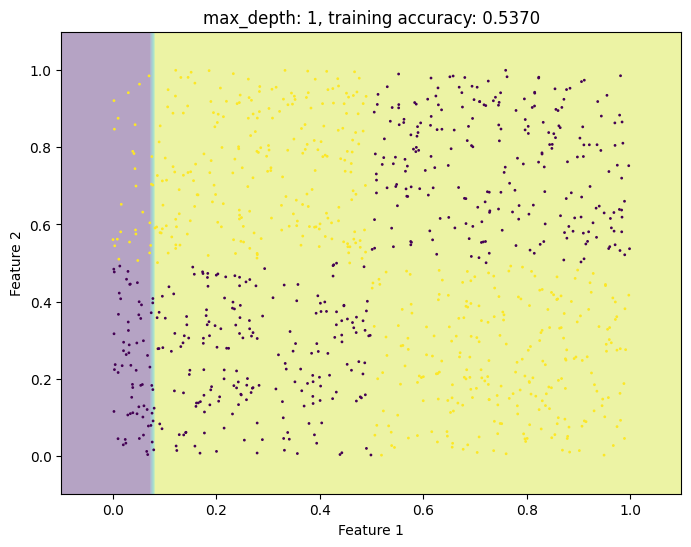

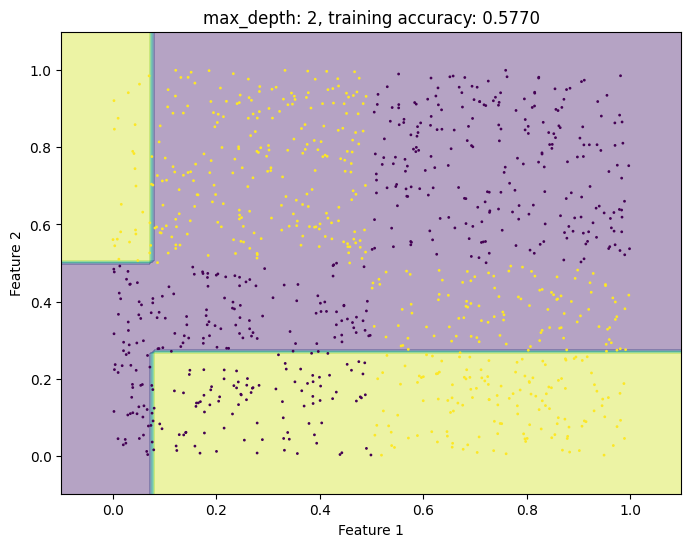

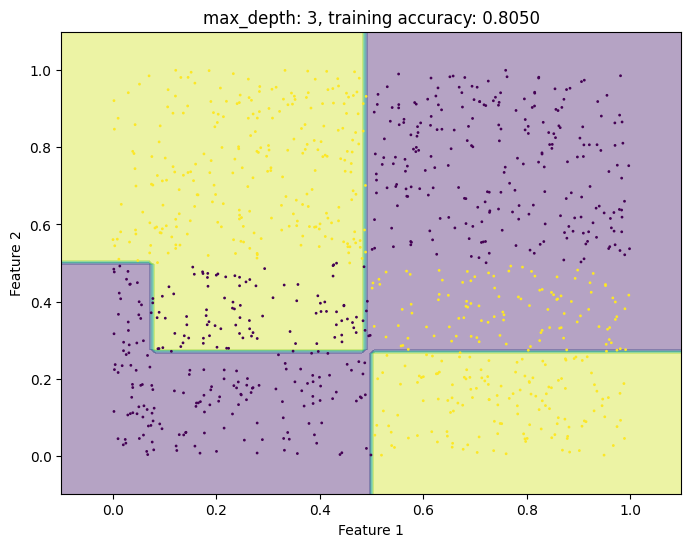

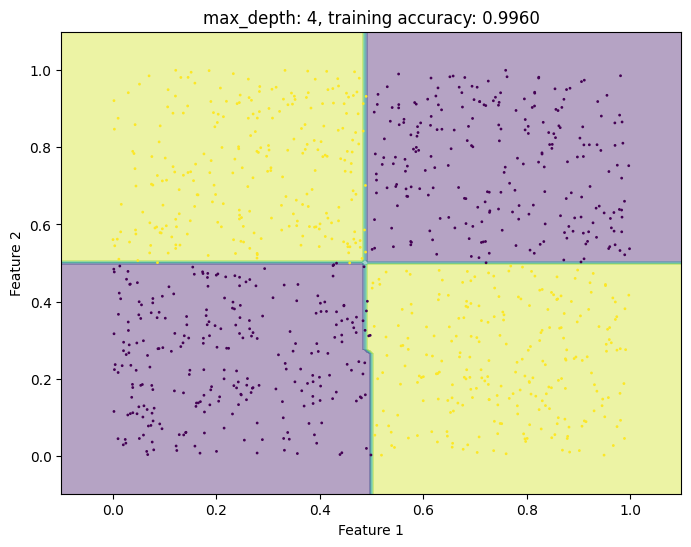

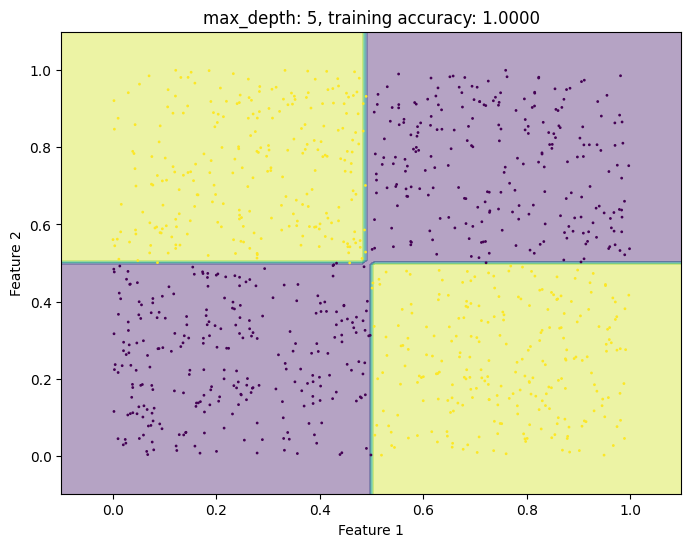

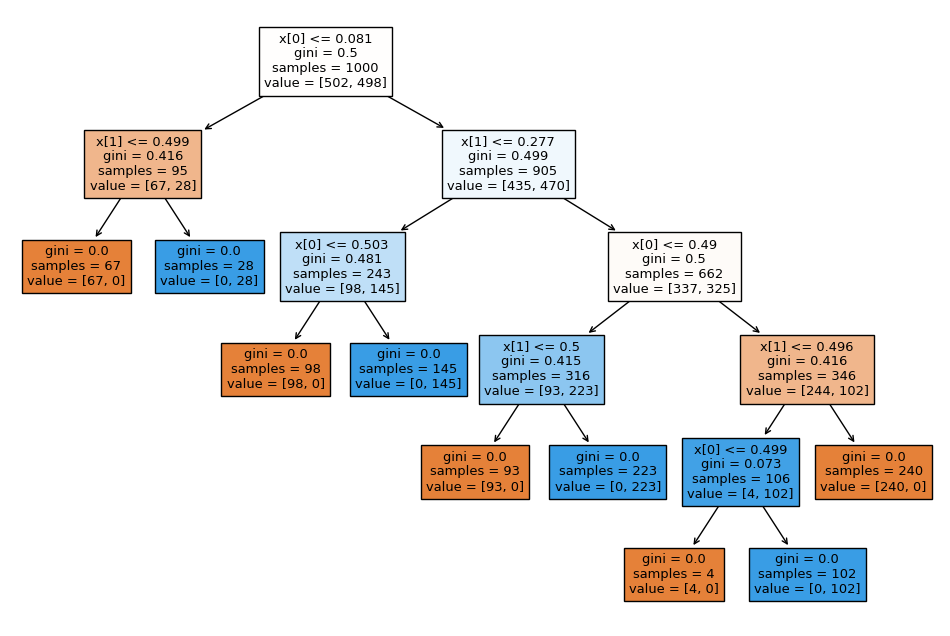

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

N = 1000
X = np.random.rand(N, 2)
y = np.logical_xor(X[:, 0] > 0.5, X[:, 1] > 0.5).astype(int)

max_depth = 1
while True:
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X, y)
    train_accuracy = clf.score(X, y)
    print(f"max_depth: {max_depth}, training accuracy: {train_accuracy:.4f}")
    if train_accuracy == 1.0:
        break
    max_depth += 1

for depth in range(1, max_depth + 1):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X, y)
    train_accuracy = clf.score(X, y)
    plt.figure(figsize=(8, 6))
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.title(f"max_depth: {depth}, training accuracy: {train_accuracy:.4f}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

clf = DecisionTreeClassifier(max_depth=max_depth)
clf.fit(X, y)
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True)
plt.show()


# Task 2 (3 points)

Consider the following dataset:

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
#print(data.DESCR)

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target_names[data.target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)


print(X_train.iloc[:5])
print(y_train[:5])

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
375       16.170         16.07          106.30      788.5          0.09880   
416        9.405         21.70           59.60      271.2          0.10440   
530       11.750         17.56           75.89      422.9          0.10730   
363       16.500         18.29          106.60      838.1          0.09686   
435       13.980         19.62           91.12      599.5          0.10600   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
375           0.14380         0.06651              0.05397         0.1990   
416           0.06159         0.02047              0.01257         0.2025   
530           0.09713         0.05282              0.04440         0.1598   
363           0.08468         0.05862              0.04835         0.1495   
435           0.11330         0.11260              0.06463         0.1669   

     mean fractal dimension  ...  worst radius  worst texture  \
375

Build a `sklearn.tree.DecisionTreeClassifier` to maximize the test ROC AUC score.

When predicting cancer, it's much more dangerous to have a false negative prediction rather than false positive. Try to find the best tree (in terms of test ROC AUC) where the labels are re-weighted with the `class_weight={'malignant' : 2., 'benign' : 1.}` argument provided to the `DecisionTreeClassifier` constructor.

Plot test ROC curves for the two best models you found on the same plot.

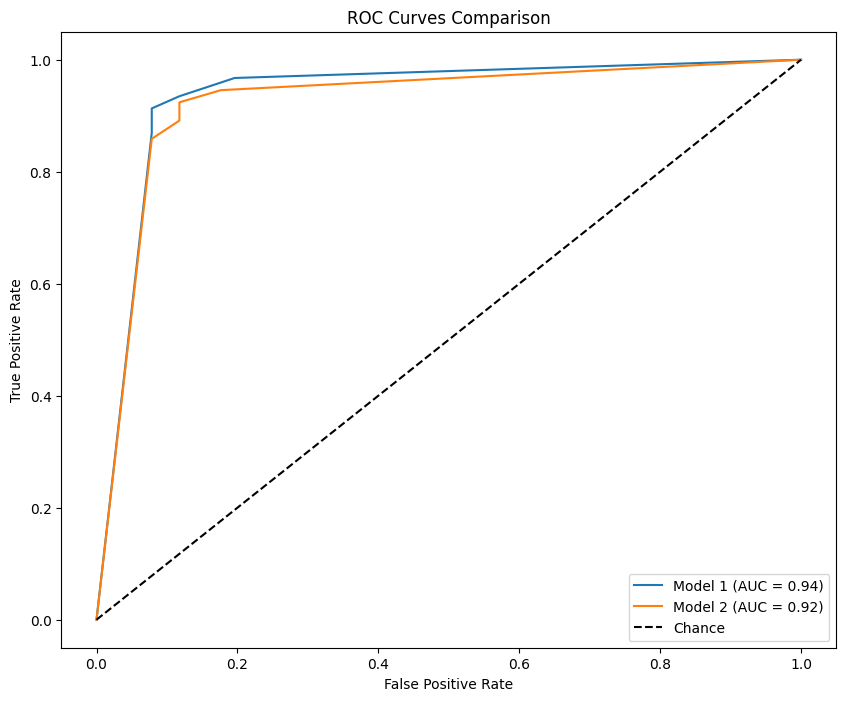

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

clf = DecisionTreeClassifier(class_weight={0: 2., 1: 1.})
param_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5)
}


grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


sorted_grid_results = sorted(grid_search.cv_results_['mean_test_score'], reverse=True)


best_score_index = np.where(grid_search.cv_results_['mean_test_score'] == sorted_grid_results[0])[0][0]
second_best_score_index = np.where(grid_search.cv_results_['mean_test_score'] == sorted_grid_results[1])[0][0]
best_clf1 = grid_search.cv_results_['params'][best_score_index]
best_clf2 = grid_search.cv_results_['params'][second_best_score_index]


clf1 = DecisionTreeClassifier(**best_clf1, class_weight={0: 2., 1: 1.})
clf2 = DecisionTreeClassifier(**best_clf2, class_weight={0: 2., 1: 1.})
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)


plt.figure(figsize=(10, 8))

for clf, label in zip([clf1, clf2], ['Model 1', 'Model 2']):
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()
